# OpenVaccine EDA

On of the most promising approaches of a COVID-19 vaccine are mRNA (messenger RNA) vaccines. One of the biggest challenges is developing stable mRNA molecules because they degrade spontaneously abd rapidly.

In this [Kaggle competition](https://www.kaggle.com/c/stanford-covid-vaccine) we have a dataset with 3000 RNA molecules and their degradation rates. Our task is to predict those degradation rates. Our models will be scores on a new generation of molecules.

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$$ \text{MCRMSE} = \frac{1}{N_t} \sum_{j=1}^{N_t} \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}, $$ where $N_t$ is the number of scored ground truth target columns, and $y$,$\hat{y}$ are the actual and predicted values respectively. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import RepeatedKFold
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import random

## Data Overview

This competition has unique and interesting data, let's analyze it.

First of all - main data is in json format, not csv which is more common on Kaggle.

In [2]:
train = pd.read_json('train.json',lines=True)
test = pd.read_json('test.json', lines=True)
sub = pd.read_csv('sample_submission.csv')

In [3]:
train.shape, train['id'].nunique(), test.shape, sub.shape

((2400, 19), 2400, (3634, 7), (457953, 6))

Notice that test and submission have different number of rows. This is because test data contains sequences and the submission is flattened. I'll show this in details later.

In [4]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2400 non-null   int64  
 1   id                   2400 non-null   object 
 2   sequence             2400 non-null   object 
 3   structure            2400 non-null   object 
 4   predicted_loop_type  2400 non-null   object 
 5   signal_to_noise      2400 non-null   float64
 6   SN_filter            2400 non-null   int64  
 7   seq_length           2400 non-null   int64  
 8   seq_scored           2400 non-null   int64  
 9   reactivity_error     2400 non-null   object 
 10  deg_error_Mg_pH10    2400 non-null   object 
 11  deg_error_pH10       2400 non-null   object 
 12  deg_error_Mg_50C     2400 non-null   object 
 13  deg_error_50C        2400 non-null   object 
 14  reactivity           2400 non-null   object 
 15  deg_Mg_pH10          2400 non-null   o

So we have 2400 samples in train dataset. Let's look at all available information about one sample

In [6]:
sample = train.loc[train['id'] == 'id_001f94081']
sample

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."


## Sequence

In [7]:
sample['sequence'].values[0]

'GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC'

In [8]:
Counter(sample['sequence'].values[0])

Counter({'G': 19, 'A': 45, 'C': 23, 'U': 20})

This is RNA sequence, a combination of A, G, U, and C for each sample. There is a separate column showing sequence length - `seq_length`. Also notice that there is column `seq_scored` - it shows that this number of positions has target values.

It is very important to remember that both `seq_length` and `seq_scored` are different in train and test. This means that we have to be able to work with sequences of different lengths.

## Structure

An array of `(, )`, and `.` characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. `(....)` means that base 0 is paired to base 5, and bases 1-4 are unpaired.

In [9]:
sample['structure'].values[0]

'.....((((((.......)))).)).((.....((..((((((....))))))..)).....))....(((((((....))))))).....................'

In [10]:
Counter(sample['structure'].values[0])

Counter({'.': 61, '(': 23, ')': 23})

### Predicted Loop Type

Describes the structural context (also referred to as 'loop type') of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop

In [11]:
sample['predicted_loop_type'].values[0]

'EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE'

In [12]:
Counter(sample['predicted_loop_type'].values[0])

Counter({'E': 26, 'S': 46, 'H': 15, 'B': 1, 'X': 5, 'I': 14})

### Important information about filtering the data!

* there were 3029 RNA sequences of length 107;
* measurements can be done only on the first 68 points of sequences;
* measurements were done in 5 conditions (reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C);
* 629 from 3029 are in public test datased. 2400 other sequences are in train;
* they were filtered using the following criteria:
    * minimal value of conditions > -0.5
    * Mean signal/noise across all conditions > 1.0. calculated as mean value divided by mean error
    * The resulting sequences were clustered into clusters with less than 50% sequence similarity, and the 629 test set sequences were chosen from clusters with 3 or fewer members. That is, any sequence in the test set should be sequence similar to at most 2 other sequences.
* train data wasn't filtered, so it could make sense to apply first two filters to training data.
* on the other hand the final scoring will be done on non-filtered data. So I suppose it would be better not to do any manual filtering in the end;

In [13]:
sample

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."


The rest of the values are our targets and their errors. Note that for scoring we need only to predict `reactivity`, `deg_Mg_pH10` and `deg_Mg_50C`.

In [14]:
len(sample['reactivity'].values[0])

68

## Train, Public Test and Private Test

In [15]:
train['seq_scored'].value_counts()

68    2400
Name: seq_scored, dtype: int64

In [16]:
test['seq_scored'].value_counts()

91    3005
68     629
Name: seq_scored, dtype: int64

Do you see that `test` has 2 unique values in `seq_scored`? rows with 68 are public test, 91 is private test.

### Preparing the Data

My idea is the following: let's try working with this data as tabular. To do this, we need to flatten the data. Let's try.

In [18]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [19]:
train_data = []
for mol_id in train['id'].unique():
    sample_data = train.loc[train['id'] == mol_id]
    for i in range(68):
        sample_tuple = (sample_data['id'].values[0], sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i],
                        sample_data['reactivity'].values[0][i], sample_data['reactivity_error'].values[0][i],
                        sample_data['deg_Mg_pH10'].values[0][i], sample_data['deg_error_Mg_pH10'].values[0][i],
                        sample_data['deg_pH10'].values[0][i], sample_data['deg_error_pH10'].values[0][i],
                        sample_data['deg_Mg_50C'].values[0][i], sample_data['deg_error_Mg_50C'].values[0][i],
                        sample_data['deg_50C'].values[0][i], sample_data['deg_error_50C'].values[0][i])
        train_data.append(sample_tuple)

In [20]:
train_data = pd.DataFrame(train_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type',
                                               'reactivity', 'reactivity_error', 'deg_Mg_pH10',
                                               'deg_error_Mg_pH10', 'deg_pH10', 'deg_error_pH10',
                                               'deg_Mg_50C', 'deg_error_Mg_50C', 'deg_50C', 'deg_error_50C'])
train_data.head()

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
0,id_001f94081,G,.,E,0.3297,0.1359,0.7556,0.2613,2.3375,0.2631,0.3581,0.1501,0.6382,0.2167
1,id_001f94081,G,.,E,1.5693,0.2070,2.9830,0.3842,3.5060,0.2860,2.9683,0.2750,3.4773,0.3475
2,id_001f94081,A,.,E,1.1227,0.1633,0.2526,0.1372,0.3008,0.0964,0.2589,0.0947,0.9988,0.1880
3,id_001f94081,A,.,E,0.8686,0.1452,1.3789,0.2531,1.0108,0.1574,1.4552,0.1866,1.3228,0.2124
4,id_001f94081,A,.,E,0.7217,0.1314,0.6376,0.1798,0.2635,0.1000,0.7244,0.1369,0.7877,0.1703


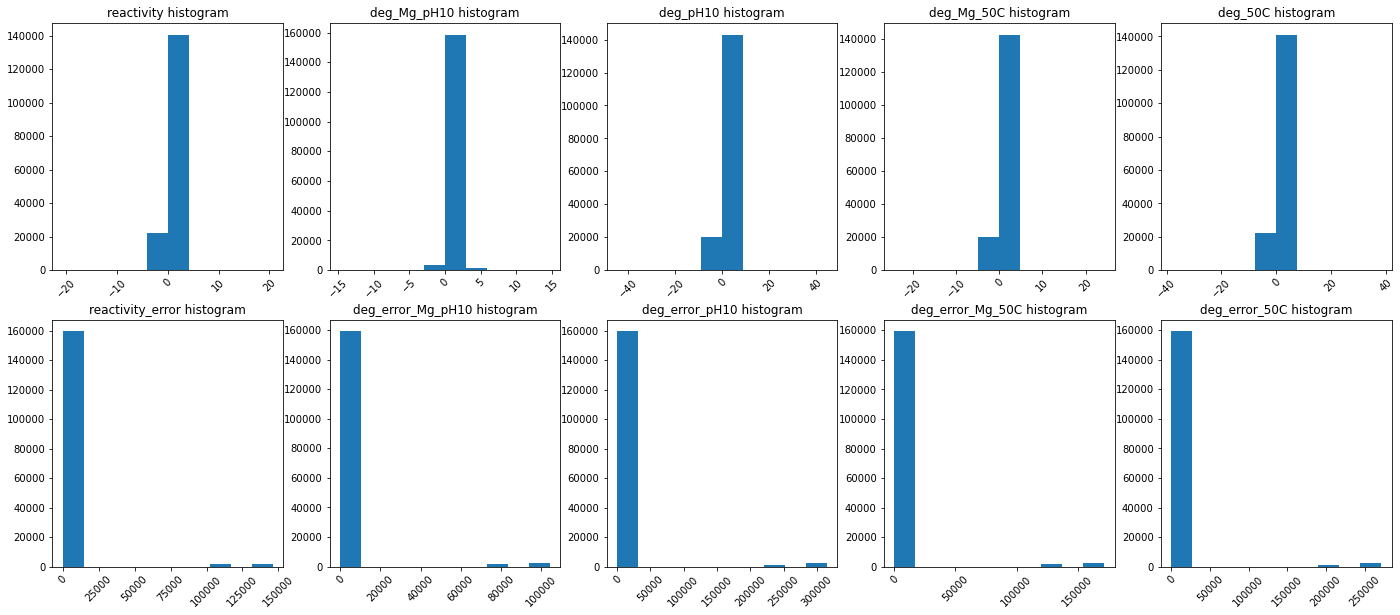

In [21]:
fig, ax = plt.subplots(figsize = (24, 10))
for i, col in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10',
                         'deg_Mg_50C', 'deg_50C', 'reactivity_error',
                         'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C']):
    plt.subplot(2, 5, i + 1);
    plt.hist(train_data[col])
    plt.title(f'{col} histogram');
    plt.xticks(rotation=45)

In [22]:
train_data.sort_values('reactivity_error')

,id,sequence,structure,predicted_loop_type,reactivity,reactivity_error,deg_Mg_pH10,deg_error_Mg_pH10,deg_pH10,deg_error_pH10,deg_Mg_50C,deg_error_Mg_50C,deg_50C,deg_error_50C
54443,id_5429cb841,A,),S,0.0000,0.0019,0.0331,0.0173,0.0608,0.0178,0.0072,0.0066,0.0233,0.0135
26991,id_2a3308237,C,),S,0.0016,0.0022,0.0426,0.0066,0.0336,0.0097,0.0481,0.0089,0.0377,0.0115
54421,id_5429cb841,U,(,S,-0.0009,0.0029,0.0250,0.0234,0.0056,0.0101,0.0019,0.0065,0.0071,0.0113
26993,id_2a3308237,A,),S,0.0024,0.0031,0.0950,0.0094,0.0641,0.0131,0.0761,0.0110,0.0547,0.0138
85089,id_8622860d7,U,(,S,0.0000,0.0031,0.0102,0.0204,0.0051,0.0105,0.0115,0.0106,0.0057,0.0117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101750,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101751,id_a1719ebbc,C,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101752,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040
101754,id_a1719ebbc,G,(,S,0.0000,146151.2250,0.0000,104235.1742,0.0000,314833.5695,0.0000,171525.3217,0.0000,271158.6040


In [23]:
train.loc[train['id'] == 'id_a1719ebbc']

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
1496,1496,id_a1719ebbc,GGAAACGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCGCCGCGCGCG...,.....((((((((((((((((((((((((((((((...))))))))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSHHHSSSSSSSS...,0.0,0,107,68,"[146151.225, 146151.225, 146151.225, 146151.22...","[104235.1742, 104235.1742, 104235.1742, 104235...","[314833.5695, 314833.5695, 314833.5695, 314833...","[171525.3217, 171525.3217, 171525.3217, 171525...","[271158.604, 271158.604, 271158.604, 271158.60...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


What are these huge errors???

In [24]:
test_data = []
for mol_id in test['id'].unique():
    sample_data = test.loc[test['id'] == mol_id]
    for i in range(sample_data['seq_scored'].values[0]):
        sample_tuple = (sample_data['id'].values[0] + f'_{i}', sample_data['sequence'].values[0][i],
                        sample_data['structure'].values[0][i], sample_data['predicted_loop_type'].values[0][i])
        test_data.append(sample_tuple)

In [25]:
test_data = pd.DataFrame(test_data, columns=['id', 'sequence', 'structure', 'predicted_loop_type'])
test_data.head()

,id,sequence,structure,predicted_loop_type
0,id_00073f8be_0,G,.,E
1,id_00073f8be_1,G,.,E
2,id_00073f8be_2,A,.,E
3,id_00073f8be_3,A,.,E
4,id_00073f8be_4,A,.,E


## Baseline Submission

Let's submit a baseline - mean value by categorical columns

In [26]:
train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['reactivity'].mean().reset_index().head()

,sequence,structure,predicted_loop_type,reactivity
0,A,(,S,0.242580
1,A,),S,0.209482
2,A,.,B,0.675737
3,A,.,E,0.567550
4,A,.,H,0.743339


In [27]:
test_data = pd.merge(test_data, train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['reactivity'].mean().reset_index(),
                     on=['sequence', 'structure', 'predicted_loop_type'])
test_data = pd.merge(test_data, train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['deg_Mg_pH10'].mean().reset_index(),
                     on=['sequence', 'structure', 'predicted_loop_type'])
test_data = pd.merge(test_data, train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['deg_pH10'].mean().reset_index(),
                     on=['sequence', 'structure', 'predicted_loop_type'])
test_data = pd.merge(test_data, train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['deg_Mg_50C'].mean().reset_index(),
                     on=['sequence', 'structure', 'predicted_loop_type'])
test_data = pd.merge(test_data, train_data.groupby(['sequence', 'structure', 'predicted_loop_type'])['deg_50C'].mean().reset_index(),
                     on=['sequence', 'structure', 'predicted_loop_type'])

In [28]:
test_data.head()

,id,sequence,structure,predicted_loop_type,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,G,.,E,0.825539,1.04461,1.747477,0.980793,0.971702
1,id_00073f8be_1,G,.,E,0.825539,1.04461,1.747477,0.980793,0.971702
2,id_000ae4237_0,G,.,E,0.825539,1.04461,1.747477,0.980793,0.971702
3,id_000ae4237_1,G,.,E,0.825539,1.04461,1.747477,0.980793,0.971702
4,id_00131c573_0,G,.,E,0.825539,1.04461,1.747477,0.980793,0.971702


In [29]:
sub.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [30]:
sub.shape, test_data.shape

((457953, 6), (316227, 9))

In [31]:
sub1 = pd.merge(sub[['id_seqpos']], test_data, left_on='id_seqpos', right_on='id', how='left').drop(['id', 'sequence', 'structure', 'predicted_loop_type'], axis=1)
sub1.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.825539,1.044610,1.747477,0.980793,0.971702
1,id_00073f8be_1,0.825539,1.044610,1.747477,0.980793,0.971702
2,id_00073f8be_2,0.567550,0.468216,0.543326,0.588278,0.593565
3,id_00073f8be_3,0.567550,0.468216,0.543326,0.588278,0.593565
4,id_00073f8be_4,0.567550,0.468216,0.543326,0.588278,0.593565


In [32]:
sub1[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']] = sub1[['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']].fillna(0) * 0.9

In [33]:
sub1.to_csv('submission.csv', index=False)

This submission obtained a private score of `0.50541` and a public score of `0.43826`, not too bad!